# LEE Analyzer Data/MC comparison plots


## Imports & Constants

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpfunction import CheckBorderTPC

%matplotlib inline

pd.options.display.max_columns = 999
gr      = 1.618

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
fid_min=10

# Fiducial volume borders in x,y,z:
fid_arr= [[10,10],[20,20],[10,50]]

In [2]:
catdefs={1: 'Cosmic',
            2: 'e CC',
            3: 'mu CC',
            4: 'NC',
            5: 'Dirt',
            6: 'Data',
            7: 'Mixed',
            0: 'Other'}



def categoryPlus(row):
    label = catdefs[row['category']]
    if row['nu_pdg']==12:
        if label=='e CC':
            return r'$\nu_e$ CC   '
        elif label=='Mixed':
            return r'$\nu_e$ cont.   '
        else:
            return label+' '*(12-len( label))
    
    elif row['nu_pdg']==14:
        if label=='mu CC':
            return r'$\nu_{\mu}$ CC       '
        elif label=='Mixed':
            return r'$\nu_{\mu}$ cont.   '
        else:
            return  label+' '*(12-len( label))
        
    elif row['nu_pdg']==4294967282 or row['nu_pdg']==4294967284:
        return r'$\bar{\nu}_{\mu} / \bar{\nu}_e$          '
    else:
        print (row['nu_pdg'])
        return 'Cosmic intime '
    
# Formatting
def sciNotSpace(x):
    x=float(x)
    return "{:4.1f}".format(x)

def closestEMobject(row):
    

## Load Pickle file

In [3]:
df_all = pd.read_pickle('Input/nu/nu_Track_BDT.pckl')
print('Dataframe loaded from Pickle has '+str(len(df_all.index))+' entries.' )


Dataframe loaded from Pickle has 169130 entries.


In [14]:
df_all = df_all[df_all.apply(lambda row: CheckBorderTPC(row['vx'],row['vy'],row['vz'],fid_arr),axis=1)]
df=df_all
print('Dataframe after fidvolcut has '+str(len(df.index))+' entries.' )
df.head(5)

Dataframe after fidvolcut has 123306 entries.


,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,category,vx,vy,vz,bnbweight,passed,shower_open_angle,shower_length,shower_start_x,shower_start_y,shower_start_z,shower_dir_x,shower_dir_y,shower_dir_z,shower_pca,track_start_x,track_start_y,track_start_z,track_end_x,track_end_y,track_end_z,track_dir_x,track_dir_y,track_dir_z,track_pca,predict_em,predict_mu,predict_cos,predict_pi,predict_p,nu_daughters_pdg,nu_daughters_E,nu_daughters_px,nu_daughters_py,nu_daughters_pz,nu_daughters_endx,nu_daughters_endy,nu_daughters_endz,true_shower_pdg,true_shower_x_sce,true_shower_y_sce,true_shower_z_sce,true_shower_depE,shower_daughter,track_daughter,shower_containment_q,shower_sp_profile,reconstructed_energy,shower_energy,shower_nhits,total_nhits,track_energy,track_nhits,shower_dedx,shower_dedx_avg,shower_dedx_hits,track_dedx,track_dedx_avg,track_dedx_hits,flash_PE,flash_time,CC_daughter_E,true_shower_endx,true_shower_endy,true_shower_endz,true_shower_tmax_x,true_shower_tmax_y,true_shower_tmax_z,matched_showers,matched_showers_energy,matched_tracks,matched_tracks_energy,catplus
0,14,1.625200,236.608551,-53.294533,929.495667,14.595528,7,233.783386,-53.704464,943.809265,0.990291,1,"[0.36108, 0.52295]","[72.312, 3.8984]","[236.12, 234.0]","[-52.219, -53.406]","[930.5, 943.5]","[-0.51172, 0.23523]","[0.85449, 0.54346]","[0.089355, -0.80566]","[0.875, 0.88184]","[233.75, 234.25, 252.75]","[-53.406, -52.844, -110.75]","[944.0, 943.0, 1004.5]","[211.75, 255.88, 256.25]","[-82.625, -46.0, -115.44]","[1004.5, 979.5, 1008.5]","[-0.28857, 0.47046, 0.49609]","[-0.3938, 0.10992, -0.66357]","[0.87256, 0.87549, 0.56006]","[0.99951, 0.99805, 1.0]","[0.00036693, 0.0023804, 0.19641]","[0.00063515, 0.0014868, 0.23828]","[0.00058985, 0.00018287, 0.3269]","[0.0007453, 0.0044289, 0.22729]","[0.99756, 0.9917, 0.01107]","[13, 2112, 211, 2212]","[0.21204, 2.0078, 0.2771, 0.99854]","[-0.0098267, -0.31616, 0.23523, 0.23999]","[0.18018, 0.068115, 0.036133, -0.1615]","[0.034912, 1.7441, 0.026749, -0.18286]","[234.5, 234.5, 234.5, 234.5]","[-58.25, -58.25, -58.25, -58.25]","[931.5, 931.5, 931.5, 931.5]",[],[],[],[],[],"[0, 0]","[0, 0, 0]",0.920455,1.161298,0.632525,"[0.159691167814, 0.0251139474596]","[94.0, 11.0]",1073,"[0.250340667884, 0.180865078381, 0.0165138769968]","[206.0, 127.0, 15.0]","[0.133967777871, 2.42227385556]","[0.210105686692, 8.7924617519]","[3.0, 5.0]","[2.72994462949, 2.32523864029, 2.06592851979]","[12.4155577748, 2.64999304698, 8.35640550776]","[14.0, 4.0, 12.0]",666.404602,3.87125,0.212016,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,"[13, 2112]","[0.212015339739, 2.00762222865]","[2112, 2112, -13]","[2.00762222865, 2.00762222865, 10.6102250314]",$\nu_{\mu}$ cont.
2,14,0.606236,111.510056,-55.260674,686.291077,88.490700,1,198.662201,-59.815376,700.932190,0.991531,1,"[0.21448, 0.34375]","[22.156, 8.1562]","[199.25, 172.12]","[-59.75, -63.469]","[701.0, 758.0]","[0.56445, -0.82812]","[0.81738, -0.56006]","[-0.11499, -0.025726]","[0.95312, 0.80469]",[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],"[14, 2112, 2112, 2000000101, 2000000101]","[0.48145, 0.99219, 0.93945, 0.029495, 0.029495]","[0.12152, -0.04953, -0.0, -0.012772, -0.089661]","[-0.21997, 0.23413, -0.0, 0.060364, -0.19092]","[0.41064, 0.21167, 0.0, 0.054565, 0.077515]","[108.25, 108.25, 108.25, 108.25, 108.25]","[-57.375, -57.375, -57.375, -57.375, -57.375]","[686.5, 686.5, 686.5, 686.5, 686.5]",[],[],[],[],[],"[0, 0]",[],0.999998,2.106096,0.054061,"[0.0421535144838, 0.011907319749]","[29.0, 10.0]",101,[],[],"[0.64546423611, 0.115358312835]","[1.99922068136, 0.259078168911]","[5.0, 6.0]",[],[],[],58.534115,3.78125,-1.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,"[-13, -13]","[13.8883073545, 13.8883073545]",[],[],Cosmic
4,14,0.541416,123.955902,-1.874746,166.989044,10.631845,3,120.681480,-11.807071,165.075089,0.994432,1,"[0.073792, 0.54053]","[12.695, 4.8281]","[122.06, 121.12]","[-8.3828, -12.953]","[164.25, 165.88]","[0.13562, -0.15344]","[0.51416, 0.96631]","[0.84717, 0.2074]","[0.9

## Plots

In [1]:
plt.style.use('default')
df.hist('bnbweight',bins=50)

NameError: name 'plt' is not defined

In [16]:
# Plot of the selected events in true neutrino energy:
df['catplus']=df.apply(categoryPlus,axis=1)

entries= len(df.index)

categories = df['catplus'].unique()
categories = ['$\\nu_{\\mu}$ CC       ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC          ',
              'Cosmic      ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ',
              '$\\nu_e$ CC   ',
              '$\\nu_e$ cont.   ']


print (categories)
true_E = []
reco_E = [] 
counter= []
labels = []

for cat in categories:
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    #print(cat)
    lab = cat+ '('+sciNotSpace(len(true_E[-1])/entries*100) +'%)'
    labels.append(lab)
    


['$\\nu_{\\mu}$ CC       ', '$\\nu_{\\mu}$ cont.   ', 'NC          ', 'Cosmic      ', 'Dirt        ', '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ', '$\\nu_e$ CC   ', '$\\nu_e$ cont.   ']


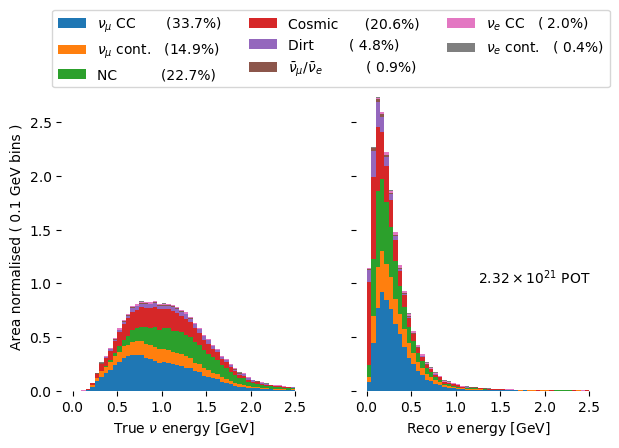

In [17]:

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=True,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 50
min_x = 0.0
max_x = 2.5
step  = 0.5

ax[0].hist(true_E,N,range=(min_x,max_x), stacked=True, fill=True,label=labels,normed=True)
ax[1].hist(reco_E,N,range=(min_x,max_x), stacked=True, fill=True,label=labels,normed=True)

ax[0].set_ylabel('Area normalised ('+sciNotSpace((max_x-min_x)/N)+' GeV bins )')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.26))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(1.25,1.0,r'$2.32 \times 10^{21}$ POT')

#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
#ax[1].spines['top'].set_visible(False)
#ax[1].spines['right'].set_visible(False)

plt.savefig("BNB_mu.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

In [8]:
categories[6]

'$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          '